<a href="https://colab.research.google.com/github/EricRibeiroAlves/Interacao-Humano-Robo/blob/main/Codigo/%5BAP_T%5D_Eric_Modelo_CNN_LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Legenda**:
- $dt$: Passo de tempo (incremento de tempo entre as amostras).
- $t$: Tempo total (ou carimbo de tempo) da amostra.
- $\frac{d\tau_{r}}{dt}$ [R_d_T]: Derivada do torque do robô (variação do torque com o tempo).
- $\tau_{r}$ [R_T]: Torque do robô.
- $S_Fx$ [R_Fx]: Sensor de torque Tx.
- $\omega_{l}$ [R_w_l]: Velocidade da coroa.
- $\theta_{l}$ [R_t_l]: Ângulo da coroa.
- $\omega_{h}$ [R_w_p]: Velocidade da pessoa.
- $\theta_{h}$ [R_t_p]: Ângulo da pessoa.
- $∫e(Interacao).dt$ [R_i_T_e]: Integral do erro de torque.
- $U(x)$ [R_u]: Sinal de controle.
- $\tau^{d}_{r}$ [R_T_d]: Torque desejado do robô.
- $\theta_{m}$ [R_t_m]: Ângulo do motor.
- $\frac{d\omega_{l}}{dt}$ [R_d_w_l]: Derivada da velocidade da coroa (variação da velocidade da coroa com o tempo).
- $phase$: Fase do movimento ou do ciclo (possivelmente relacionada à fase da marcha).
- $\theta_{m, L}$ [L_t_m]: Ângulo do motor na perna esquerda.
- $\theta_{l, L}$ [L_t_l]: Ângulo da coroa na perna esquerda.
- $L_u$: Sinal de controle aplicado ao lado esquerdo.
- $\tau_{r, L}$ [L_T_r]: Torque real no lado esquerdo.
- $\tau^{d}_{r, L}$ [L_T_d]: Torque desejado no lado esquerdo.

### Variáveis adicionais (não presentes no dataset mas relevantes no código):
- $\tau_{i}$ [R_T_i]: Torque de interação.

# Bibliotecas

In [1]:
# Trato dos dados
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from google.colab import drive

# Libs p/ Modelo Deep LTSM
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, LSTM, Dense, Dropout, BatchNormalization
from tensorflow.keras.losses import Huber
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

# 1º Passo: Montar o Drive e carregar o dataset


In [2]:
drive.mount('/content/drive')
t6_markov = "drive/MyDrive/Markov/T6/last_data_MarkovMao 1.dat"
head_markov = ['dt', 't', 'R_d_T', 'R_T', 'R_Fx', 'R_w_l', 'R_t_l', 'R_w_p', 'R_t_p',
               'R_i_T_e', 'R_u', 'R_T_d', 'R_t_m', 'R_d_w_l', 'phase', 'L_t_m',
               'L_t_l', 'L_u', 'L_T_r', 'L_T_d']
pd.set_option('display.float_format', lambda x: '%.10f' % x)
markov_t6 = pd.read_table(t6_markov, header=None, names=head_markov, index_col=False)

Mounted at /content/drive


In [3]:
data = markov_t6.iloc[1275:]
# Remover linhas onde R_w_l é zero
data = data.loc[data['R_w_l'] != 0]

<ipython-input-4-1312485550>:9: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


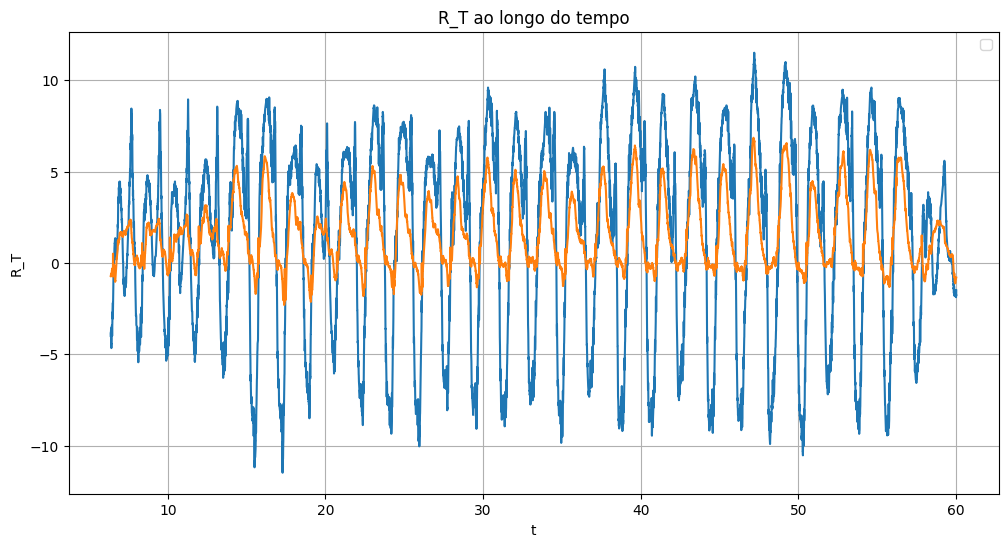

In [4]:
# Gráfico de linha para uma coluna
plt.figure(figsize=(12, 6))
plt.grid(True)
plt.plot(data['t'].iloc[:], data['R_T'].iloc[:])
plt.plot(data['t'].iloc[:], data['R_T_d'].iloc[:])
plt.title('R_T ao longo do tempo')
plt.xlabel('t')
plt.ylabel('R_T')
plt.legend()
plt.grid(True)
plt.show()

# 2º Passo: Cálculo (Markov 6, Dados Completos)

In [5]:
Ka = 0.1  # Rigidez do acessório
Ba = 1  # Amortecimento do acessório
data['tau_i'] = Ka * (data['R_t_p'] - data['R_t_l']) + Ba * (data['R_w_p'] - data['R_w_l'])
data['d_tau_i'] = np.gradient(data['tau_i'])

# 3º Passo: Separação e Normalização dos dados


In [6]:
dataset = data.copy()
X = dataset[['R_t_p', 'R_t_l', 'R_w_p', 'R_w_l', 'phase']]  # Inputs
y = dataset[['R_T_d']]  # Saída: torque desejado (já calculado pelo sistema)
scaler_X = MinMaxScaler(feature_range=(0, 1))
scaler_y = MinMaxScaler(feature_range=(0, 1))
X_scaled = scaler_X.fit_transform(X)
y_scaled = scaler_y.fit_transform(y.values.reshape(-1, 1))

# 4º Passo: Criar sequências de dados para LSTM

In [7]:
timesteps = 350  # Ajustar conforme a análise
n_features = X_scaled.shape[1]

def create_sequences(X, y, timesteps):
    Xs, ys = [], []
    for i in range(len(X) - timesteps):
        Xs.append(X[i:i+timesteps])
        ys.append(y[i+timesteps])
    return np.array(Xs), np.array(ys)

X_train, y_train = create_sequences(X_scaled, y_scaled, timesteps)
print("Forma dos dados de entrada para LSTM:", X_train.shape)
print("Forma dos dados de saída:", y_train.shape)

Forma dos dados de entrada para LSTM: (9143, 350, 5)
Forma dos dados de saída: (9143, 1)


# 5º Passo: Definição do Modelo LSTM otimizado

In [8]:
model_cnn_lstm = Sequential()

# Ajustar o input_shape para refletir o número de características (4)
model_cnn_lstm.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(timesteps, n_features), padding='causal'))
model_cnn_lstm.add(MaxPooling1D(pool_size=2))

# Camada LSTM com return_sequences para empilhar
model_cnn_lstm.add(LSTM(128, return_sequences=True))
model_cnn_lstm.add(Dropout(0.2))

# Camada LSTM final
model_cnn_lstm.add(LSTM(64, return_sequences=False))
model_cnn_lstm.add(Dropout(0.2))

# Camada de saída (regressão - sem ativação)
model_cnn_lstm.add(Dense(1))

# Compilação para regressão (usando Huber ou MSE)
model_cnn_lstm.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss=Huber(),  # Alternativa: 'mse'
    metrics=['MAE', 'MSE']
)

model_cnn_lstm.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                 │ (None, 350, 64)        │         1,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 175, 64)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 175, 128)       │        98,816 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 175, 128)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 64)             │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 149,313 (583.25 KB)

 Trainable params: 149,313 (583.25 KB)

 Non-trainable params: 0 (0.00 B)

# 6º Passo: Treinamento do Modelo

In [9]:
# Treinamento do modelo
history = model_cnn_lstm.fit(
    X_train, y_train,
    epochs=256,            # Número de épocas ajustável
    batch_size=32,        # Lote para atualização dos pesos
    validation_split=0.4, # Separação para validação
    verbose=1             # Exibição detalhada do progresso
)

Epoch 1/256
172/172 ━━━━━━━━━━━━━━━━━━━━ 11s 26ms/step - MAE: 0.0841 - MSE: 0.0159 - loss: 0.0079 - val_MAE: 0.0633 - val_MSE: 0.0077 - val_loss: 0.0039
Epoch 2/256
172/172 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - MAE: 0.0457 - MSE: 0.0036 - loss: 0.0018 - val_MAE: 0.0629 - val_MSE: 0.0070 - val_loss: 0.0035
Epoch 3/256
172/172 ━━━━━━━━━━━━━━━━━━━━ 7s 29ms/step - MAE: 0.0448 - MSE: 0.0035 - loss: 0.0017 - val_MAE: 0.0613 - val_MSE: 0.0063 - val_loss: 0.0032
Epoch 4/256
172/172 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - MAE: 0.0402 - MSE: 0.0028 - loss: 0.0014 - val_MAE: 0.0548 - val_MSE: 0.0050 - val_loss: 0.0025
Epoch 5/256
172/172 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - MAE: 0.0388 - MSE: 0.0026 - loss: 0.0013 - val_MAE: 0.0556 - val_MSE: 0.0053 - val_loss: 0.0026
Epoch 6/256
172/172 ━━━━━━━━━━━━━━━━━━━━ 7s 28ms/step - MAE: 0.0381 - MSE: 0.0025 - loss: 0.0012 - val_MAE: 0.0559 - val_MSE: 0.0057 - val_loss: 0.0029
Epoch 7/256
172/172 ━━━━━━━━━━━━━━━━━━━━ 4s 24ms/step - MAE: 0.0360 - MSE: 0.0022 - los

# 7º Passo: Avaliação e Previsão

In [10]:
y_pred_scaled = model_cnn_lstm.predict(X_train)
y_pred = scaler_y.inverse_transform(y_pred_scaled)
y_train_rescaled = scaler_y.inverse_transform(y_train)

# Métricas adicionais
r2 = r2_score(y_train_rescaled, y_pred)
mae = mean_absolute_error(y_train_rescaled, y_pred)
rmse = np.sqrt(mean_squared_error(y_train_rescaled, y_pred))

print(f'R²: {r2}')
print(f'MAE: {mae:.4f} Nm')
print(f'RMSE: {rmse:.4f} Nm')

286/286 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step
R²: 0.9302467649645223
MAE: 0.2763 Nm
RMSE: 0.4833 Nm


# 8º Passo: Visualização das perdas (train vs validation)

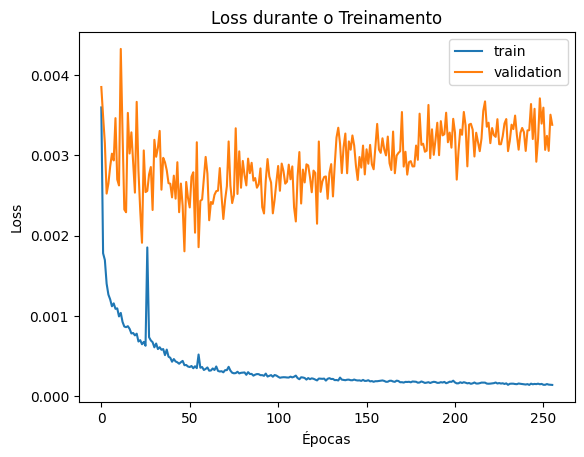

In [11]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='validation')
plt.legend()
plt.title("Loss durante o Treinamento")
plt.xlabel("Épocas")
plt.ylabel("Loss")
plt.show()

# 9º Passo: Gráfico comparativo entre valores reais e previsões

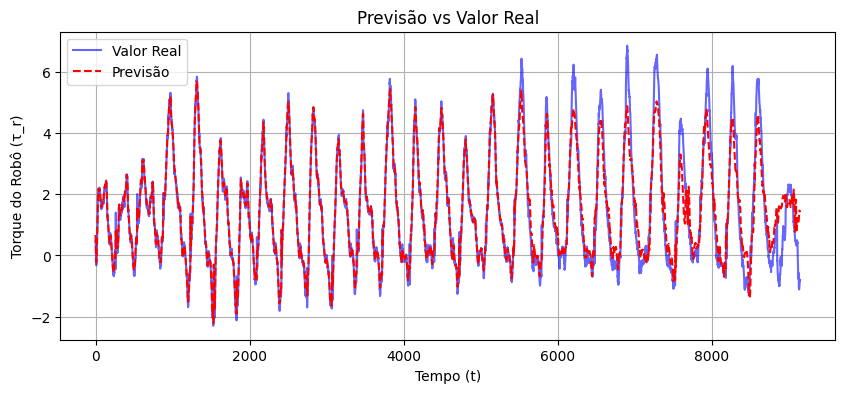

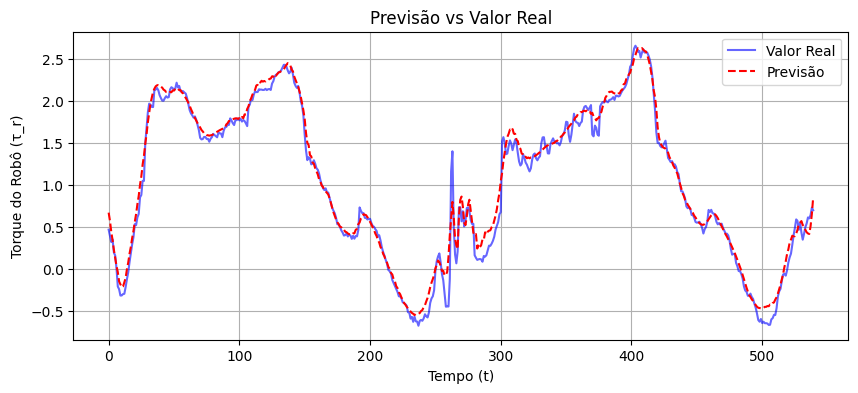

In [12]:
def plot_predictions(y_true, y_pred, title='Previsão vs Valor Real'):
    plt.figure(figsize=(10, 4))
    plt.plot(y_true.flatten(), label='Valor Real', color='blue', alpha=0.6)
    plt.plot(y_pred.flatten(), label='Previsão', color='red', linestyle='--', alpha=1)
    plt.title(title)
    plt.xlabel('Tempo (t)')
    plt.ylabel('Torque do Robô (τ_r)')
    plt.legend()
    plt.grid(True)
    plt.show()

# Exibir previsões vs valores reais para uma parte do dataset
plot_predictions(y_train_rescaled[:], y_pred[:])
plot_predictions(y_train_rescaled[:540], y_pred[:540])



# 10º Passo: Erro

In [13]:
# Calcular o erro como a diferença entre os valores reais e preditos
erro = y_train_rescaled.flatten() - y_pred.flatten()

#11º Passo: Plot do Erro

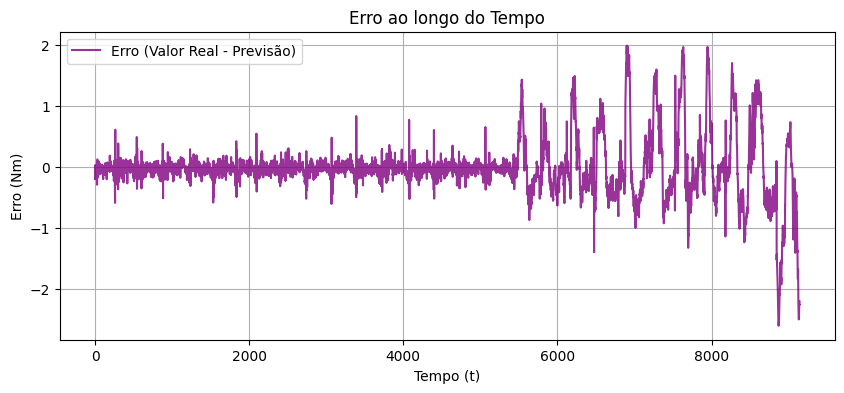

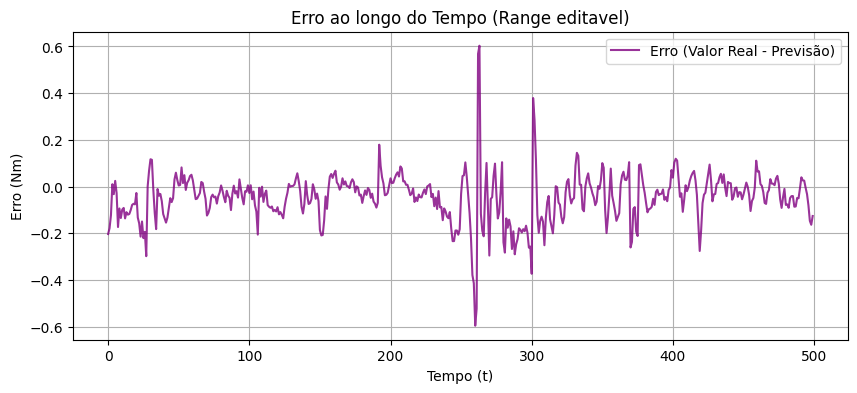

Média do Erro: -0.0221 Nm
Desvio Padrão do Erro: 0.4828 Nm


In [14]:
# Plotar o erro no tempo
plt.figure(figsize=(10, 4))
plt.plot(erro[:], label='Erro (Valor Real - Previsão)', color='purple', alpha=0.8)
plt.title('Erro ao longo do Tempo')
plt.xlabel('Tempo (t)')
plt.ylabel('Erro (Nm)')
plt.legend()
plt.grid(True)
plt.show()

# Exibir o erro apenas para uma janela de tempo específica (por exemplo, primeiros 3000 pontos)
plt.figure(figsize=(10, 4))
plt.plot(erro[:500], label='Erro (Valor Real - Previsão)', color='purple', alpha=0.8)
plt.title('Erro ao longo do Tempo (Range editavel)')
plt.xlabel('Tempo (t)')
plt.ylabel('Erro (Nm)')
plt.legend()
plt.grid(True)
plt.show()

# Estatísticas do erro
mean_error = np.mean(erro)
std_error = np.std(erro)
print(f'Média do Erro: {mean_error:.4f} Nm')
print(f'Desvio Padrão do Erro: {std_error:.4f} Nm')

In [15]:
model_cnn_lstm.evaluate(X_train, y_train, verbose=2)
model_cnn_lstm.save('drive/MyDrive/Markov/Modelo CNN LSTM/model_cnn_lstm_Markov6.h5')
model_cnn_lstm.save_weights('drive/MyDrive/Markov/Modelo CNN LSTM/model_cnn_lstm_weights_Markov6.weights.h5')
json_string = model_cnn_lstm.to_json()

286/286 - 2s - 7ms/step - MAE: 0.0302 - MSE: 0.0028 - loss: 0.0014
